Psychiatric History    0
Medical History        0
Substance Use          0
dtype: int64
Psychiatric History    0
Medical History        0
Substance Use          0
dtype: int64
Model: SVC
Cross-validation mean accuracy: 0.9890
Training set accuracy: 0.9890
Validation set accuracy: 0.9900



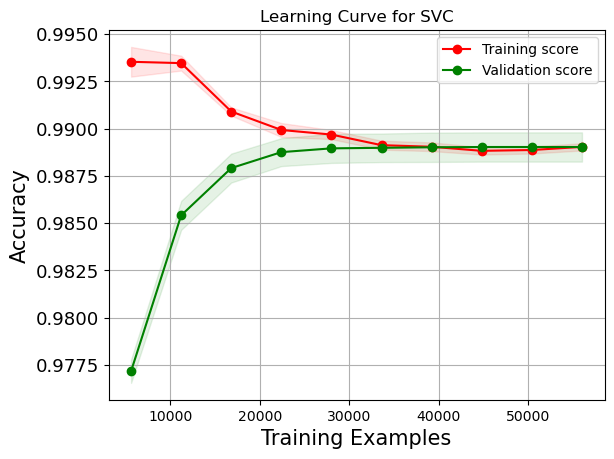

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Load datasets
df_train = pd.read_csv('panic_disorder_dataset_training.csv')
df_test = pd.read_csv('panic_disorder_dataset_testing.csv')

# Drop Participant ID from training and test data
df_train = df_train.drop(columns=['Participant ID'])
df_test = df_test.drop(columns=['Participant ID'])

# List of columns to impute, in order of least to most missing values
columns_to_impute = ['Psychiatric History', 'Medical History', 'Substance Use']

# Function to impute a column using Random Forest
def impute_column(df, target_column, features):
    train_data = df[df[target_column].notnull()]
    test_data = df[df[target_column].isnull()]

    X_train = train_data[features]
    y_train = train_data[target_column]
    X_test = test_data[features]

    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    model = RandomForestClassifier() if df[target_column].dtype == 'object' else RandomForestRegressor()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    df.loc[df[target_column].isnull(), target_column] = predictions
    return df

# List of features to use for imputation
features_train = [col for col in df_train.columns if col not in columns_to_impute + ['Participant ID']]
for column in columns_to_impute:
    df_train = impute_column(df_train, column, features_train)

features_test = [col for col in df_test.columns if col not in columns_to_impute + ['Participant ID']]
for column in columns_to_impute:
    df_test = impute_column(df_test, column, features_test)

# Verify no missing values
print(df_test[columns_to_impute].isnull().sum())
print(df_train[columns_to_impute].isnull().sum())

# Split data into training and validation sets
X = df_train.drop(columns=['Panic Disorder Diagnosis'])
y = df_train['Panic Disorder Diagnosis']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define categorical and numerical features
categorical_features = ['Gender', 'Family History', 'Personal History', 'Current Stressors', 'Symptoms', 
                        'Severity', 'Impact on Life', 'Demographics', 'Medical History', 'Psychiatric History', 
                        'Substance Use', 'Coping Mechanisms', 'Social Support', 'Lifestyle Factors']
numerical_features = ['Age']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define models
models = {
    'SVC': SVC(random_state=42),
}

# Evaluate each model using cross-validation and compare performance
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    kfold = StratifiedKFold(n_splits=5)

    # Cross-validate models
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='accuracy')
    
    # Fit the model on the training set and evaluate on the validation set
    pipeline.fit(X_train, y_train)
    train_score = pipeline.score(X_train, y_train)
    val_score = pipeline.score(X_val, y_val)
    
    print(f"Model: {model_name}")
    print(f"Cross-validation mean accuracy: {cv_results.mean():.4f}")
    print(f"Training set accuracy: {train_score:.4f}")
    print(f"Validation set accuracy: {val_score:.4f}\n")

    # Plot learning curve
    train_sizes, train_scores, val_scores = learning_curve(pipeline, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure()
    plt.title(f'Learning Curve for {model_name}')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label='Training score')
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label='Validation score')

    plt.legend(loc='best')
    plt.show()


In [10]:
# Preprocess test data
X_test = df_test.drop(columns=['Panic Disorder Diagnosis'])
y_test = df_test['Panic Disorder Diagnosis']

# Evaluate the final model on a separate test set
svc_test_score = pipeline.score(X_test, y_test)
print(f"SVC Test Accuracy: {svc_test_score:.4f}")

SVC Test Accuracy: 0.9899


In [7]:
# Define the new instance
new_instance = pd.DataFrame({
    'Age': [38],
    'Gender': ['Male'],
    'Family History': ['Yes'],
    'Personal History': ['Yes'],
    'Current Stressors': ['High'],
    'Symptoms': ['Panic attacks'],
    'Severity': ['Severe'],
    'Impact on Life': ['Mild'],
    'Demographics': ['Rural'],
    'Medical History': ['Diabetes'],
    'Psychiatric History': ['Anxiety disorder'],
    'Substance Use': ['Drugs'],
    'Coping Mechanisms': ['Seeking therapy'],
    'Social Support': ['High'],
    'Lifestyle Factors': ['Sleep quality']
})

# Apply preprocessing to the new instance
new_instance_transformed = pipeline.named_steps['preprocessor'].transform(new_instance)

# Use the trained SVC pipeline to make predictions
svc_prediction = pipeline.named_steps['classifier'].predict(new_instance_transformed)

# Print the predictions
print("SVC Prediction for the new instance:")
print(svc_prediction[0])

NameError: name 'pipeline' is not defined

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# SVM
svm_predictions = pipeline.predict(X_val)
print("SVM Classification Report:")
print(classification_report(y_val, svm_predictions))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_val, svm_predictions))


SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     28715
           1       0.81      1.00      0.90      1285

    accuracy                           0.99     30000
   macro avg       0.91      0.99      0.94     30000
weighted avg       0.99      0.99      0.99     30000

SVM Confusion Matrix:
[[28414   301]
 [    0  1285]]


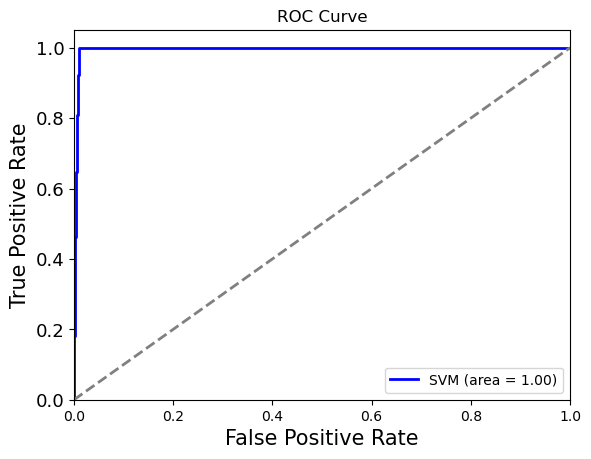

In [16]:
from sklearn.metrics import roc_curve, auc

# SVM
svm_proba = pipeline.decision_function(X_val)
fpr_svm, tpr_svm, _ = roc_curve(y_val, svm_proba)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'SVM (area = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Evaluating performance for feature: Age


C:\Users\rebec\AppData\Local\Temp\ipykernel_20464\3651666924.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  performance_by_bin = df.groupby('feature_bin').apply(lambda group: accuracy_score(group['target'], group['prediction']))


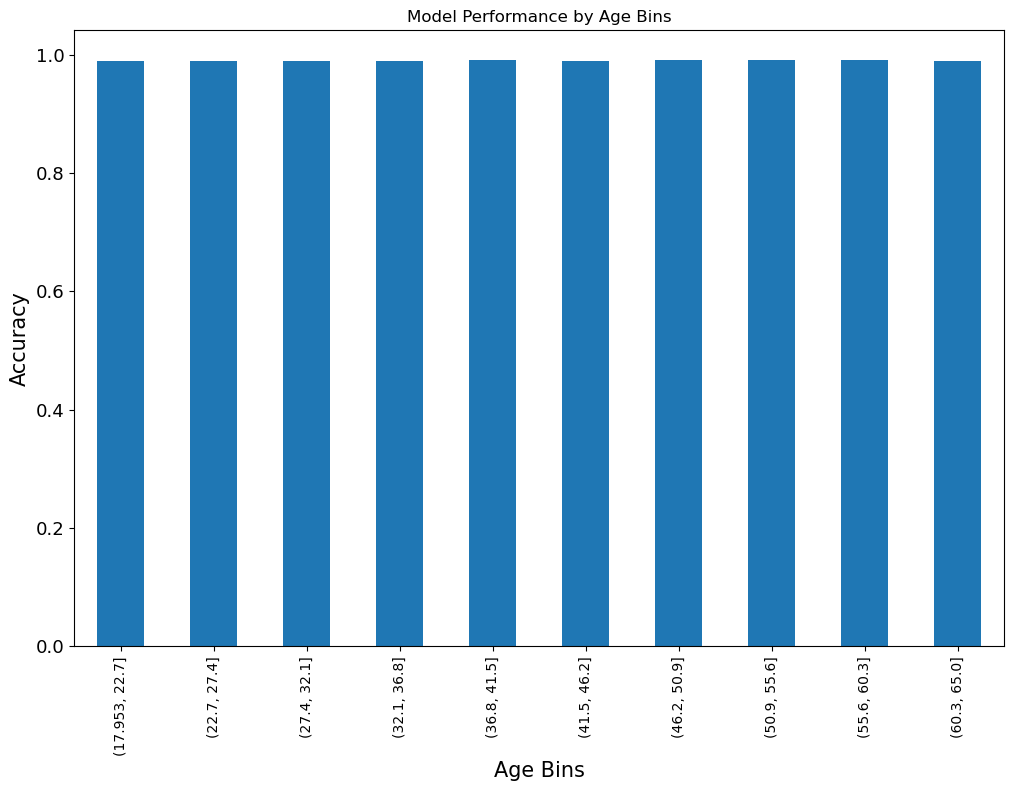

feature_bin
(17.953, 22.7]    0.989158
(22.7, 27.4]      0.989470
(27.4, 32.1]      0.989396
(32.1, 36.8]      0.988581
(36.8, 41.5]      0.991399
(41.5, 46.2]      0.988736
(46.2, 50.9]      0.990848
(50.9, 55.6]      0.991798
(55.6, 60.3]      0.991489
(60.3, 65.0]      0.988584
dtype: float64


KeyboardInterrupt: 

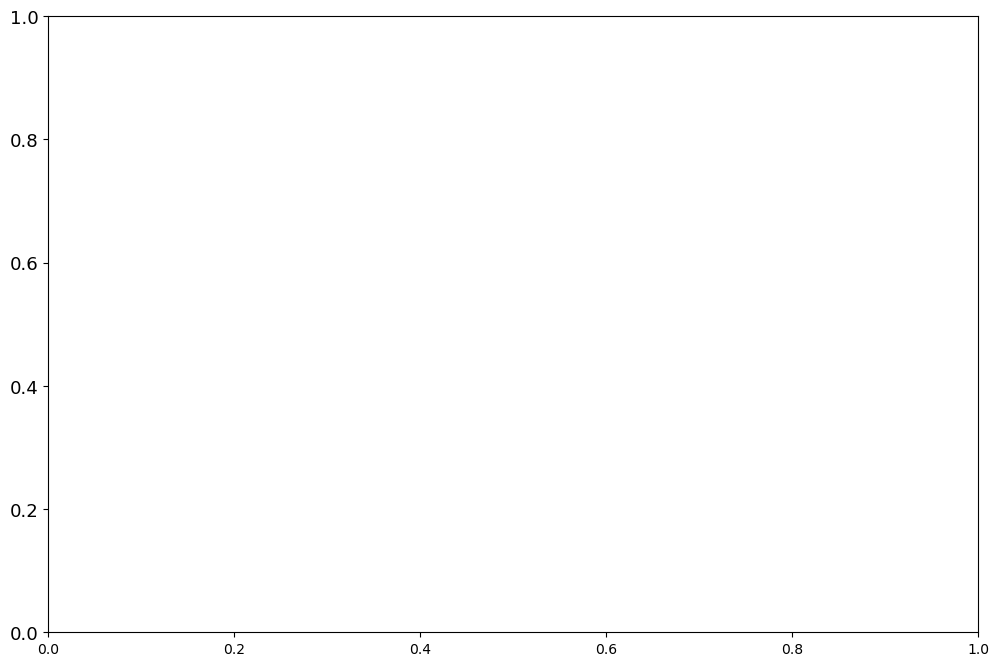

In [22]:

from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Function to evaluate model performance for specific feature values
def evaluate_performance_by_feature(model, X, y, feature, bins=10):
    df = X.copy()
    df['target'] = y
    df['prediction'] = model.predict(X)
    
    # Discretize the feature into bins
    df['feature_bin'] = pd.cut(df[feature], bins=bins)
    
    performance_by_bin = df.groupby('feature_bin').apply(lambda group: accuracy_score(group['target'], group['prediction']))
    
    plt.figure(figsize=(12, 8))
    performance_by_bin.plot(kind='bar')
    plt.title(f'Model Performance by {feature} Bins')
    plt.xlabel(f'{feature} Bins')
    plt.ylabel('Accuracy')
    plt.show()
    
    return performance_by_bin

# Access the trained model (assuming it's the SVC)
trained_pipeline = pipeline

# Evaluate performance for numerical features
for feature in numerical_features:
    print(f"Evaluating performance for feature: {feature}")
    performance_by_bin = evaluate_performance_by_feature(trained_pipeline, X_val, y_val, feature)
    print(performance_by_bin)

# Plot partial dependence plots for important features
features_to_plot = numerical_features  # You can add more features here

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(trained_pipeline, X_train, features_to_plot, ax=ax, grid_resolution=50, kind='both')
plt.subplots_adjust(top=0.9)
fig.suptitle('Partial Dependence and ICE Plots for SVC', fontsize=16)
plt.show()

In [23]:
import pickle

# Save the SVC model to a pickle file
with open('svc_model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)